In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product

import pandas as pd
import numpy as np

from index_option_analysis import solve_marks, spot_compute_iv, spot_greeks_from

In [2]:
# We will work with a familiar portfolio
basic_folio = pd.DataFrame.from_records(
    [(141, 'PUT', 680,  40 * 5),
     (141, 'PUT', 800, -80 * 5),
     (141, 'PUT', 855,  5 * 5),
     (141, 'PUT', 860,  35 * 5),
     (141, 'CALL', 960, -40 * 5),
     (168, 'CALL', 960,  10 * 5),
     (168, 'CALL', 965,  30 * 5),
    ],
    columns=['dte','putCall','strikePrice','quantity'],
)

basic_folio

,dte,putCall,strikePrice,quantity
0,141,PUT,680,200
1,141,PUT,800,-400
2,141,PUT,855,25
3,141,PUT,860,175
4,141,CALL,960,-200
5,168,CALL,960,50
6,168,CALL,965,150


In [3]:
# load option prices as of the snapshot time
option_data = pd.read_csv('../data/generic_at_330pm.csv')
option_data

,strikePrice,dte,putCall,bid,ask
0,40.0,22,CALL,877.80,879.24
1,80.0,22,CALL,837.82,839.24
2,120.0,22,CALL,797.82,799.24
3,160.0,22,CALL,757.84,759.26
4,200.0,22,CALL,717.86,719.26
...,...,...,...,...,...
4571,1380.0,778,PUT,457.82,462.62
4572,1400.0,778,PUT,477.06,481.86
4573,1420.0,778,PUT,496.34,501.14
4574,1440.0,778,PUT,515.66,520.46


In [4]:
dtes = sorted(option_data.dte.unique())

print('Available dtes: ')
print(dtes)

Available dtes: 
[22, 50, 85, 113, 141, 168, 204, 232, 260, 295, 323, 358, 386, 414, 449, 596, 778]


In [5]:
# add some useful fields to the option data
chains = option_data.copy()
chains['is_call'] = (chains.putCall == 'CALL')
chains['tau'] = chains['dte'] / 365.
chains['mark'] = 0.5 * (chains['bid'] + chains['ask'])


In [16]:
puts_calls = (chains.pivot(['dte','strikePrice'],'putCall','mark')
             .dropna(how='any')
             .reset_index())
gb = puts_calls.groupby('dte')

min_strike_width = 100
max_strike_width = 500
min_strike = 500
max_strike=1300

int_rates = {}
fwds = {}
for dte in dtes:
    
    tau = dte / 365.

    cp = gb.get_group(dte).set_index('strikePrice')[['CALL','PUT']]

    strike_pairs = [(k1,k2) for k1,k2 in product(cp.index, cp.index)
                            if (k1 + min_strike_width <= k2)
                            and (k1 + max_strike_width >= k2)
                            and (k1 > min_strike) and (k2 < max_strike)]

    disc_facts = [ 
        ((cp.CALL[k1] - cp.CALL[k2]) + (cp.PUT[k2] - cp.PUT[k1]))
            / (k2 - k1)
        for (k1,k2) in strike_pairs
    ]
    int_rates[dte] = np.mean([np.log(df) / (-tau) for df in disc_facts])
    
    fwds[dte] = ((cp.CALL - cp.PUT)*np.exp(-tau*int_rates[dte]) + cp.index).median()
rates = pd.DataFrame(dict(int_rate=int_rates, fwd=fwds))
rates.index.name = 'dte'
rates['tau'] = rates.index.to_series() / 365.
rates['spot'] = rates.fwd.iloc[0] # approximate spot with front-month forward
rates['div_yld'] = np.log(rates.spot/rates.fwd)/(rates.tau) + rates.int_rate

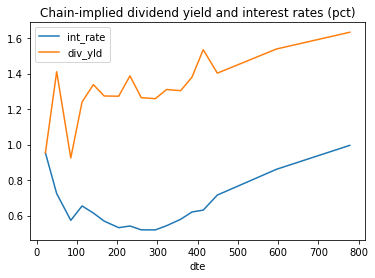

In [20]:
(100*rates[['int_rate','div_yld']]).plot(title='Chain-implied dividend yield and interest rates (pct)');

In [23]:
chains_with_rates = pd.merge(chains, rates.drop('tau',axis=1), on='dte')

In [26]:
chains_with_rates

,strikePrice,dte,putCall,bid,ask,is_call,tau,mark,int_rate,fwd,spot,div_yld
0,40.0,22,CALL,877.80,879.24,True,0.060274,878.52,0.009536,918.614307,918.614307,0.009536
1,80.0,22,CALL,837.82,839.24,True,0.060274,838.53,0.009536,918.614307,918.614307,0.009536
2,120.0,22,CALL,797.82,799.24,True,0.060274,798.53,0.009536,918.614307,918.614307,0.009536
3,160.0,22,CALL,757.84,759.26,True,0.060274,758.55,0.009536,918.614307,918.614307,0.009536
4,200.0,22,CALL,717.86,719.26,True,0.060274,718.56,0.009536,918.614307,918.614307,0.009536
...,...,...,...,...,...,...,...,...,...,...,...,...
4571,1380.0,778,PUT,457.82,462.62,False,2.131507,460.22,0.009958,906.227189,918.614307,0.016327
4572,1400.0,778,PUT,477.06,481.86,False,2.131507,479.46,0.009958,906.227189,918.614307,0.016327
4573,1420.0,778,PUT,496.34,501.14,False,2.131507,498.74,0.009958,906.227189,918.614307,0.016327
4574,1440.0,778,PUT,515.66,520.46,False,2.131507,518.06,0.009958,906.227189,918.614307,0.016327


In [28]:

folio_cols = ['price','delta','theta','gamma','vega','wt_vega']

folio = pd.merge(chains_with_rates, basic_folio, on=['dte','putCall','strikePrice'])

# compute implied vol for each option
folio['imp_vol'] = spot_compute_iv(
    tgt=folio.mark,
    spot=folio.spot,
    strike=folio.strikePrice,
    tau=folio.tau,
    is_call=folio.is_call,
    int_rate=folio.int_rate,
    div_yld=folio.div_yld,
)

# compute greeks for each option
greeks = spot_greeks_from(
    spot=folio.spot,
    strike=folio.strikePrice,
    tau=folio.tau,
    sigma=folio.imp_vol,
    is_call=folio.is_call,
    int_rate=folio.int_rate,
    div_yld=folio.div_yld,
)

for c in folio_cols:
    folio[c] = greeks[c]

# adjust for the 100 multiplier
# note that vega needs no adjustment
folio['value'] = 100*folio['price'] # value per contract
folio['theta'] *= 100/365.          # per contract
folio['delta'] *= 100               # per contract

In [55]:
# Compute portfolio value and greeks
folio_greeks = folio[folio_cols+['value']].mul(folio.quantity, axis=0).sum()
print('Portfolio greeks:\n')
print(folio_greeks.round(2))

print("""
Basic Version had these values:

price        479.00
delta        -21.08 ***
theta        776.05
gamma         -0.09
vega       -1406.29
wt_vega    -2337.75
value      47900.00

""") 

Portfolio greeks:

price        479.00
delta         13.39
theta        757.49
gamma         -0.10
vega       -1274.14
wt_vega    -2308.76
value      47900.00
dtype: float64

Basic Version had these values:

price        479.00
delta        -21.08 ***
theta        776.05
gamma         -0.09
vega       -1406.29
wt_vega    -2337.75
value      47900.00




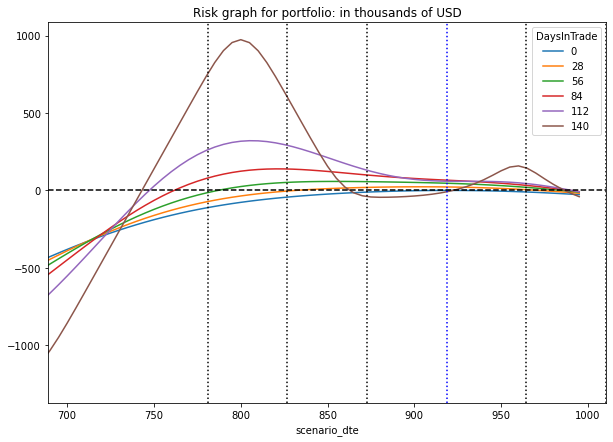

In [41]:
future_dtes = [0, 28, 56, 84, 112, 140]
spots = list(range(600,1000,5))
risk_graph = []
for fut_dte in future_dtes:
    for spot in spots:
        greeks = spot_greeks_from(
            spot=spot,
            strike=folio.strikePrice,
            tau=folio.tau - fut_dte/365.,
            is_call=folio.is_call,
            sigma=folio.imp_vol,
            int_rate=folio.int_rate, # note: int_rate and div_yld are also "sticky"
            div_yld=folio.div_yld,   # and do not roll down the term structure.
        ) 
        risk_graph.append((fut_dte, spot, 100*(greeks['price']*folio['quantity']).sum()))

rg = pd.DataFrame.from_records(risk_graph, columns=['dte','spot','value'])
rg['PnL'] = rg.value - folio_greeks.value

spot = folio.spot.iloc[0]
rgs = rg.pivot('spot','dte','PnL')
rgs.index.name = 'scenario_dte'
rgs.columns.name = 'scenario_spot'
rgs.columns.name = 'DaysInTrade'
(rgs/1000).plot(figsize=(10,7), xlim=[spot * 0.75, spot*1.1], 
         title='Risk graph for portfolio: in thousands of USD');
plt.axhline(y=0., color='k', linestyle='--')
for pct in [0.85, 0.9, 0.95, 1., 1.05, 1.1]:
    color = 'b' if pct==1 else 'k'
    plt.axvline(x=spot*pct, color=color, linestyle=':')

In [45]:
spot_15pct_down = ((spot* 0.85) // 5) * 5
pm_slice_15pct_down = rgs.loc[spot_15pct_down, 0]
print('Approx portfolio margin: ', np.abs(pm_slice_15pct_down).round())
print('Basic version:            114290.0')

Approx portfolio margin:  112998.0
Basic version:            114290.0


In [50]:
spot_0pct_down = ((spot * 1) // 5) * 5
atm_slice = rgs.loc[spot_0pct_down]
print(atm_slice.round(2))
#atm_slice.plot(title='ATM Pnl slice');
_='''
Basic Version has this:
DaysInTrade
0          0.00
28     23054.46
56     47676.06
84     68058.15
112    61157.01
140   -10648.09
''';

DaysInTrade
0       -113.80
28     22864.28
56     47570.23
84     68146.52
112    60348.60
140   -16416.29
Name: 915, dtype: float64


In [52]:
print(spot)
_='''Basic spot was: 915'''

918.6143071067737


## We should see better alignment of put and call implied vols 

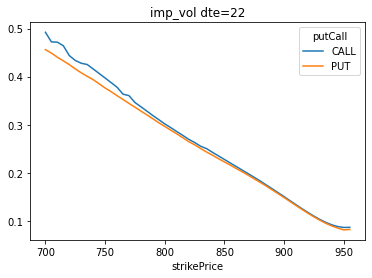

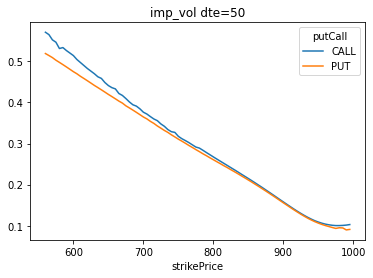

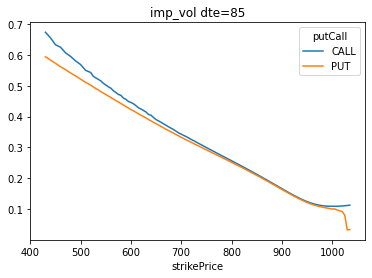

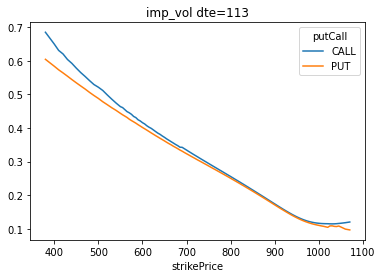

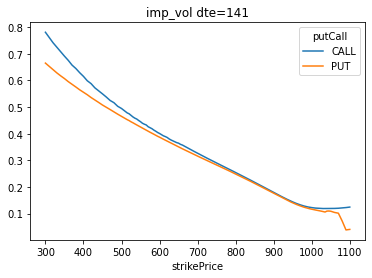

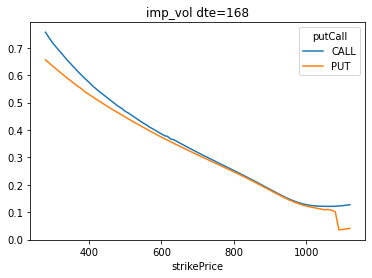

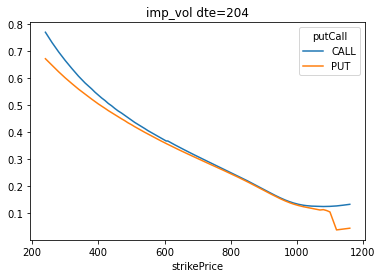

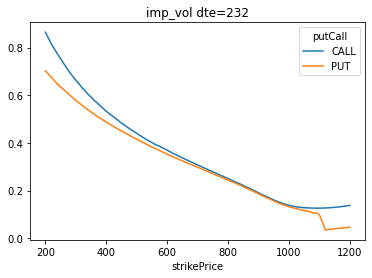

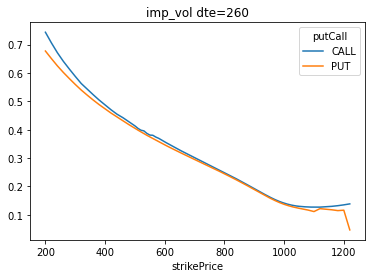

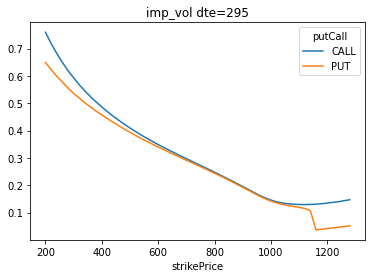

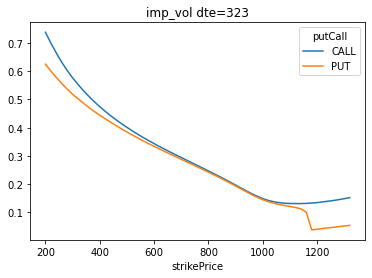

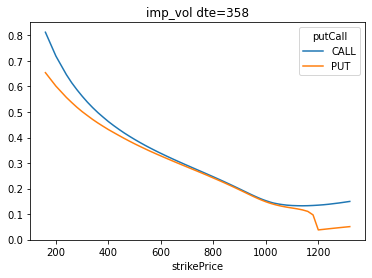

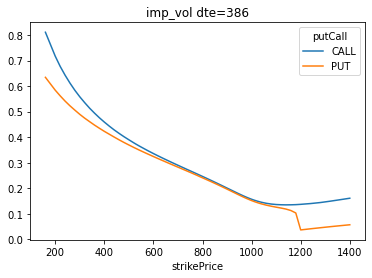

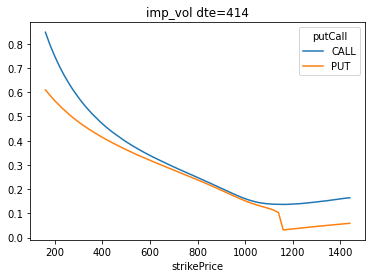

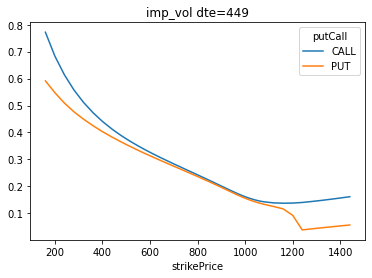

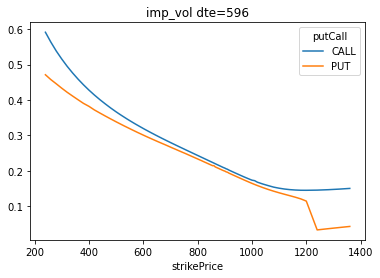

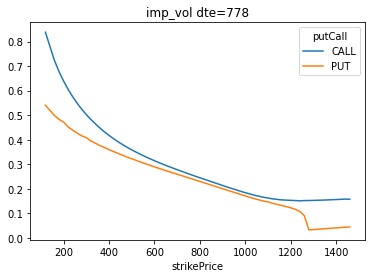

In [54]:
chains = chains_with_rates
chains['imp_vol'] = spot_compute_iv(
    tgt=chains.mark,
    spot=chains.spot,
    strike=chains.strikePrice,
    tau=chains.tau,
    is_call=chains.is_call,
    int_rate=chains.int_rate,
    div_yld=chains.div_yld,
)

for dte,df in chains.groupby('dte'):
    df.pivot('strikePrice','putCall','imp_vol').dropna().plot(title=f'imp_vol dte={dte}');